In [27]:
import copy
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [60]:

#define backdoor

#backdoor are the parent nodes. i.e node S,A have no parents. node St has parents S,A
#backdoor={'S':[],'A':[],'St':['S','A'],'sav':['S','A'],'hous':['S','A'],'Cred':['S','A']}

#### TO CHECK
backdoor={'brand':[],'color':['brand'],'category':['brand'],'quality':['brand'],'price':['brand','quality'],
          'sentiment':['brand','category','quality'],'rating':['brand','category','quality','price','color','sentiment']}


In [61]:
def get_combination(lst,tuplelst):
    i=0
    new_tuplelst=[]
    if len(tuplelst)==0:
        l=lst[0]
        for v in l:
            new_tuplelst.append([v])
        if len(lst)>1:
            return get_combination(lst[1:],new_tuplelst)
        else:
            return new_tuplelst
    

    currlst=lst[0]
    for l in tuplelst:
        
        for v in currlst:
            newl=copy.deepcopy(l)
            newl.append(v)
            new_tuplelst.append(newl)
        
    if len(lst)>1:
        return get_combination(lst[1:],new_tuplelst)
    else:
        return new_tuplelst

def get_C_set(df,C):
    lst=[]
    for Cvar in C:
        lst.append(list(set(list(df[Cvar]))))
        
    combination_lst= (get_combination(lst,[]))
    
    return combination_lst

def get_val(row,target,target_val):
    i=0
    while i<len(target):
        if not float(row[target[i]])==float(target_val[i]):
            return 0
        i+=1
    return 1

def train_regression(df,conditional,conditional_values,target,target_val):
    new_lst=[]
    count=0
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
        if new_lst[-1]==1:
            count+=1
    if len(conditional)==0:
        return count*1.0/df.shape[0]
    if len(list(set(new_lst)))==1:
        if new_lst[0]==1:
            return 1
        else:
            return 0
        
    if len(conditional)>0:
        X=df[conditional]
    else:
        X=df
    
    ###CHANGE
    regr = RandomForestRegressor(random_state=0)
    #regr = LogisticRegression(random_state=0)
    regr.fit(X.values, new_lst)
    #print('regr is:', regr)
    return regr

def train_regression_raw(df,conditional,conditional_values,AT):
    new_lst=[]
    count=0
    '''
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
        if new_lst[-1]==1:
            count+=1
    if len(conditional)==0:
        return count*1.0/df.shape[0]
    if len(list(set(new_lst)))==1:
        if new_lst[0]==1:
            return 1
        else:
            return 0
    '''
    if len(conditional)>0:
        X=df[conditional]
    else:
        X=df
    ###CHANGE
    regr = RandomForestRegressor(random_state=0)
    #regr = LinearRegression()#random_state=0)
    regr.fit(X, df[AT])
    return regr

def get_prob_o_regression(df,conditional,conditional_values,target,target_val):
    new_lst=[]
    count=0
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
        if new_lst[-1]==1:
            count+=1
    if len(conditional)==0:
        return count*1.0/df.shape[0]
    if len(list(set(new_lst)))==1:
        if new_lst[0]==1:
            return 1
        else:
            return 0
        
    if len(conditional)>0:
        X=df[conditional]
    else:
        X=df
    start = time.process_time()

    regr = RandomForestRegressor(random_state=0)
    
    #regr = LogisticRegression(random_state=0)
    regr.fit(X, new_lst)
    #print("timesssssssss",time.process_time() - start)

    #print (regr.coef_.tolist())
    #print (regr.predict_proba([conditional_values]),"ASDFDS")
    print ("heeeeeere")
    #return (regr.predict([conditional_values].values)[0])
    #CHANGE HERE
    return (regr.predict([conditional_values])[0])
    #return(regr.predict_proba([conditional_values])[0][1])
  

In [97]:
def get_query_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c):
    #interference is set of attributes of other tuples in a block that affect current tuple's attribute
    #blocks are list of lists
    
    #Identify all attributes which are used for regression and add as columns 
    
            
    #print (len(sub_df),len(sub_intervene))
    if q_type=='count':
        conditioning_set=prelst
        #        intervention=
        backdoorlst=[]
        for attr in Ac:
            backdoorlst.extend(backdoor[attr])
        backdoorlst=list(set(backdoorlst))
        if len(backdoorlst)>0:
            backdoorvals=get_C_set(df,backdoorlst)
            #print(backdoorvals)
        else:
            backdoorvals=[]
        total_prob=0
        regr=''
        iter=0
        for backdoorvallst in backdoorvals:
            conditioning_set=[]
            conditioning_set.extend(prelst)
            conditioning_set.extend(Ac)
            conditioning_set.extend(backdoorlst)

            conditioning_val=[]
            conditioning_val.extend(prevallst)
            conditioning_val.extend(c)
            conditioning_val.extend(backdoorvallst)

            #print ("conditioning set",conditioning_set,conditioning_val)
            #print("post condition",postlst,postvallst)
            if iter==0:
                start = time.process_time()

                regr=train_regression(df,conditioning_set,conditioning_val,postlst,postvallst)
                #print("time",time.process_time() - start)
            #print (conditioning_val)
            print(regr)
            pogivenck= regr.predict([conditioning_val])[0]#(get_prob_o_regression(df,conditioning_set,conditioning_val,postlst,postvallst))
            #print("this",prelst,prevallst,backdoorlst,backdoorvallst)
            pcgivenk = (get_prob_o_regression(df,prelst,prevallst,backdoorlst,backdoorvallst))
            #print (pogivenck,pcgivenk)
            total_prob+=pogivenck * pcgivenk
            iter+=1
            
        print("final prob is ",total_prob)
        #print (iter)
        return total_prob
    if q_type=='avg':
        
        conditioning_set=prelst
        #        intervention=
        backdoorlst=[]
        for attr in Ac:
            backdoorlst.extend(backdoor[attr])
        backdoorlst=list(set(backdoorlst))
        if len(backdoorlst)>0:
            backdoorvals=get_C_set(df,backdoorlst)
            print(backdoorvals)
        else:
            backdoorvals=[[]]
        total_prob=0
        regr=''
        iter=0
        print (backdoorvals)
        
        
        for backdoorvallst in backdoorvals:
            
            conditioning_set=[]
            conditioning_set.extend(prelst)
            conditioning_set.extend(Ac)
            conditioning_set.extend(backdoorlst)

            conditioning_val=[]
            conditioning_val.extend(prevallst)
            conditioning_val.extend(c)
            conditioning_val.extend(backdoorvallst)

            #print ("conditioning set",conditioning_set,conditioning_val, AT)
            if iter==0:
                regr=train_regression_raw(df,conditioning_set,conditioning_val,AT)
                
            pogivenck= regr.predict([conditioning_val])[0]#(get_prob_o_regression(df,conditioning_set,conditioning_val,postlst,postvallst))
            #print("this",prelst,prevallst,backdoorlst,backdoorvallst)
            pcgivenk = (get_prob_o_regression(df,prelst,prevallst,backdoorlst,backdoorvallst))
            #print (pogivenck,pcgivenk)
            total_prob+=pogivenck * pcgivenk
            iter+=1
            
        #print("final prob is ",total_prob)
        return total_prob


In [ ]:
def convert_cate_features(df, cate_cols):
    le_dict = {}
    for col in cate_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
    return df, le_dict

###use for overall updates
def groupby_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c,g_Ac_lst,interference, blocks, group_attr):
    #convert categorical features
    cate_cols = ['category','brand','color']
    df_new, le_dict = convert_cate_features(df, cate_cols)

    ### get outputs group by attribute
    print(le_dict)
    group_attr_vals = list(set(df_new[group_attr]))
    le = le_dict[group_attr]
    for i in range(len(prelst)):
        pre = prelst[i]
        preval_cate = prevallst[i]
        if pre in cate_cols:
            preval = le_dict[pre].transform([preval_cate])[0]
            prevallst[i] = preval

    score_ls = []
    for val in group_attr_vals:
        ###TO DO: postlst & postvallst
        score_val = get_query_output(df,q_type,AT,prelst,prevallst,postlst.append(group_attr),postvallst.append(val),Ac,c,g_Ac_lst,interference, blocks)#,{0:[1,2]})
        val_name = le.classes_[val]
        #print(val_name)
        score_ls.append([val_name,score_val])
    return score_ls

###use for vary updates
def vary_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,const_ls, g_Ac_lst,interference, blocks):
    #convert categorical features
    cate_cols = ['category','brand','color']
    df_new, le_dict = convert_cate_features(df, cate_cols)
    print('df',df)
    print('df_new', df_new)
    ### get outputs group by attribute
    #print(le_dict)
    for i in range(len(prelst)):
        pre = prelst[i]
        preval_cate = prevallst[i]
        if pre in cate_cols:
            preval = le_dict[pre].transform([preval_cate])[0]
            prevallst[i] = preval
    #group_attr_vals = list(set(df_new[group_attr]))
    #le = le_dict[group_attr]
    score_ls = []
    for const in const_ls:
        ###TO DO: postlst & postvallst
        score_val = get_query_output(df_new,q_type,AT,prelst,prevallst,postlst,postvallst.append,Ac,[const],g_Ac_lst,interference, blocks)#,{0:[1,2]})
        #print(val_name)
        score_ls.append([const,score_val])
    return score_ls

In [37]:
### process data 

#bucketize price
df_product = pd.read_csv('products.csv')

def bucketize_price(price):
    bucket_size = 50
    bucket_center = 25
    return (price // bucket_size) * bucket_size + bucket_center

df_product["price"] = df_product["price"].apply(bucketize_price)
print(df_product)



       pid category      brand      color  quality  price
0        0   Laptop      Apple     silver     0.95   1375
1        1   Laptop      Apple       grey     0.75   1125
2        2   Laptop      Apple  starlight     0.95   1275
3        3   Laptop      Apple  starlight     0.80   1125
4        4   Laptop      Apple       grey     0.85   1175
...    ...      ...        ...        ...      ...    ...
2986  2986   Camera      Canon      black     0.60    275
2987  2987   Camera       Sony      black     0.60    225
2988  2988   Camera      Canon      black     0.95    375
2989  2989   Camera  Panasonic      black     0.70    275
2990  2990   Camera      Canon      black     0.65    225

[2991 rows x 6 columns]


In [38]:
df_product.to_csv('amazon_product_new.csv', index=False)

In [39]:
####import new data here

df_product = pd.read_csv('amazon_product_new.csv')
df_rating =pd.read_csv('amazon_rating_new.csv')


In [40]:
df_product

pid category      brand      color  quality  price
0        0   Laptop      Apple     silver     0.95   1375
1        1   Laptop      Apple       grey     0.75   1125
2        2   Laptop      Apple  starlight     0.95   1275
3        3   Laptop      Apple  starlight     0.80   1125
4        4   Laptop      Apple       grey     0.85   1175
...    ...      ...        ...        ...      ...    ...
2986  2986   Camera      Canon      black     0.60    275
2987  2987   Camera       Sony      black     0.60    225
2988  2988   Camera      Canon      black     0.95    375
2989  2989   Camera  Panasonic      black     0.70    275
2990  2990   Camera      Canon      black     0.65    225

[2991 rows x 6 columns]

In [41]:
df_rating

pid   rid    rating  sentiment
0        0     0  3.300000   0.505000
1        1     1  3.200000   0.477500
2        2     2  3.050000   0.457500
3        3     3  3.050000   0.462500
4        4     4  3.250000   0.470000
...    ...   ...       ...        ...
2986  2986  2986  4.416667   0.675000
2987  2987  2987  4.333333   0.645833
2988  2988  2988  4.500000   0.670833
2989  2989  2989  4.666667   0.695833
2990  2990  2990  4.666667   0.691667

[2991 rows x 4 columns]

In [50]:
df = pd.merge(df_product,df_rating,left_on='pid', right_on='pid',how='inner')

df = df.drop(columns=['pid','rid'])
#df2 = df
print(df)

     category      brand      color  quality  price    rating  sentiment
0      Laptop      Apple     silver     0.95   1375  3.300000   0.505000
1      Laptop      Apple       grey     0.75   1125  3.200000   0.477500
2      Laptop      Apple  starlight     0.95   1275  3.050000   0.457500
3      Laptop      Apple  starlight     0.80   1125  3.050000   0.462500
4      Laptop      Apple       grey     0.85   1175  3.250000   0.470000
...       ...        ...        ...      ...    ...       ...        ...
2986   Camera      Canon      black     0.60    275  4.416667   0.675000
2987   Camera       Sony      black     0.60    225  4.333333   0.645833
2988   Camera      Canon      black     0.95    375  4.500000   0.670833
2989   Camera  Panasonic      black     0.70    275  4.666667   0.695833
2990   Camera      Canon      black     0.65    225  4.666667   0.691667

[2991 rows x 7 columns]


In [51]:
def convert_cate_features(df, cate_cols):
    le_dict = {}
    for col in cate_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
    return df, le_dict

In [52]:
cate_cols = ['category','brand','color']
df_new, le_dict = convert_cate_features(df, cate_cols)

In [57]:
#sample
def get_output(group_df, new_price):
    return group_df['quality'].mean()

def get_weighted_average_score(df, const):
    df['new_price'] = df['price'] * const
    grouped_df = df.groupby('price')
    
    scores = []
    weights = []

    for old_price, group in grouped_df:
        #print(old_price, group['new_price'].iloc[0], group)
        group_score = get_output(group, group['new_price'].iloc[0])
        group_weight = len(group)
        
        scores.append(group_score)
        weights.append(group_weight)

    weighted_avg_score = np.average(scores, weights=weights)
    return weighted_avg_score, scores, weights

weighted_avg_score, scores, weights = get_weighted_average_score(df, 1.2)
print(weighted_avg_score)


0.7047475760615179


In [79]:
###NEW: get weighted average score
#problem: result still the same
def get_weighted_avg_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c_sign, c_const,g_Ac_lst,interference, blocks):
    update_attr = Ac[0]
    
    grouped_df = df.groupby(update_attr)
    
    scores = []
    weights = []

    for old_val, df_group in grouped_df:
        if c_sign == '+':
            c = old_val + c_const
        elif c_sign == 'x':
            c = old_val * c_const
        print(c)
        print(Ac)
        group_score = get_query_output(df_group,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,[c],g_Ac_lst,interference, blocks)
        group_weight = len(df_group)
        
        scores.append(group_score)
        weights.append(group_weight)

    weighted_avg_score = np.average(scores, weights=weights)
    return weighted_avg_score


In [92]:
update_attr ='price'
    
grouped_df = df.groupby(update_attr)

scores = []
weights = []

In [94]:
const = 1.2

In [93]:
for old_val, df_group in grouped_df:
    print(old_val)
    new_val = old_val*const
    print('new val:' new_val)
    #print(old_price, group['new_price'].iloc[0], group)
    #group_score = get_query_output(df_group,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,[c],g_Ac_lst,interference, blocks)
    group_score = get_query_output(df_group,'avg','rating',['brand'],[1],[],[],'price',[c],g_Ac_lst,interference, blocks)
    group_weight = len(df_group)
    
    scores.append(group_score)
    weights.append(group_weight)



In [95]:
#problem: for df_temp, the results are the same
df_temp = df[df['price'] == 625]

In [96]:
df_temp

category  brand  color  quality  price    rating  sentiment  new_price
328          1      1      0     0.80    625  3.714286   0.552381      750.0
333          1      1      1     0.65    625  3.285714   0.488095      750.0
335          1      1      0     0.65    625  3.619048   0.535714      750.0
344          1      1      0     0.95    625  3.190476   0.476190      750.0
365          1      1      0     0.85    625  3.142857   0.480952      750.0
...        ...    ...    ...      ...    ...       ...        ...        ...
1977         1      3      1     0.80    625  4.045455   0.606818      750.0
1987         1      3      0     0.60    625  3.954545   0.568182      750.0
2006         1      3      0     0.85    625  4.000000   0.609091      750.0
2010         1      3      1     0.80    625  3.863636   0.577273      750.0
2031         1      3      1     0.65    625  4.181818   0.634091      750.0

[158 rows x 8 columns]

In [99]:
get_query_output(df_temp,'avg','rating',['brand'],[1],[],[],['price'],[725])

[[0.8, 8], [0.8, 1], [0.8, 3], [0.8, 4], [0.65, 8], [0.65, 1], [0.65, 3], [0.65, 4], [0.85, 8], [0.85, 1], [0.85, 3], [0.85, 4], [0.6, 8], [0.6, 1], [0.6, 3], [0.6, 4], [0.95, 8], [0.95, 1], [0.95, 3], [0.95, 4], [0.75, 8], [0.75, 1], [0.75, 3], [0.75, 4], [0.45, 8], [0.45, 1], [0.45, 3], [0.45, 4], [0.55, 8], [0.55, 1], [0.55, 3], [0.55, 4], [0.5, 8], [0.5, 1], [0.5, 3], [0.5, 4], [0.9, 8], [0.9, 1], [0.9, 3], [0.9, 4], [0.7, 8], [0.7, 1], [0.7, 3], [0.7, 4]]
[[0.8, 8], [0.8, 1], [0.8, 3], [0.8, 4], [0.65, 8], [0.65, 1], [0.65, 3], [0.65, 4], [0.85, 8], [0.85, 1], [0.85, 3], [0.85, 4], [0.6, 8], [0.6, 1], [0.6, 3], [0.6, 4], [0.95, 8], [0.95, 1], [0.95, 3], [0.95, 4], [0.75, 8], [0.75, 1], [0.75, 3], [0.75, 4], [0.45, 8], [0.45, 1], [0.45, 3], [0.45, 4], [0.55, 8], [0.55, 1], [0.55, 3], [0.55, 4], [0.5, 8], [0.5, 1], [0.5, 3], [0.5, 4], [0.9, 8], [0.9, 1], [0.9, 3], [0.9, 4], [0.7, 8], [0.7, 1], [0.7, 3], [0.7, 4]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere


3.466685665348159

In [100]:
get_query_output(df_temp,'avg','rating',['brand'],[1],[],[],['price'],[525])

[[0.8, 8], [0.8, 1], [0.8, 3], [0.8, 4], [0.65, 8], [0.65, 1], [0.65, 3], [0.65, 4], [0.85, 8], [0.85, 1], [0.85, 3], [0.85, 4], [0.6, 8], [0.6, 1], [0.6, 3], [0.6, 4], [0.95, 8], [0.95, 1], [0.95, 3], [0.95, 4], [0.75, 8], [0.75, 1], [0.75, 3], [0.75, 4], [0.45, 8], [0.45, 1], [0.45, 3], [0.45, 4], [0.55, 8], [0.55, 1], [0.55, 3], [0.55, 4], [0.5, 8], [0.5, 1], [0.5, 3], [0.5, 4], [0.9, 8], [0.9, 1], [0.9, 3], [0.9, 4], [0.7, 8], [0.7, 1], [0.7, 3], [0.7, 4]]
[[0.8, 8], [0.8, 1], [0.8, 3], [0.8, 4], [0.65, 8], [0.65, 1], [0.65, 3], [0.65, 4], [0.85, 8], [0.85, 1], [0.85, 3], [0.85, 4], [0.6, 8], [0.6, 1], [0.6, 3], [0.6, 4], [0.95, 8], [0.95, 1], [0.95, 3], [0.95, 4], [0.75, 8], [0.75, 1], [0.75, 3], [0.75, 4], [0.45, 8], [0.45, 1], [0.45, 3], [0.45, 4], [0.55, 8], [0.55, 1], [0.55, 3], [0.55, 4], [0.5, 8], [0.5, 1], [0.5, 3], [0.5, 4], [0.9, 8], [0.9, 1], [0.9, 3], [0.9, 4], [0.7, 8], [0.7, 1], [0.7, 3], [0.7, 4]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere


3.466685665348159

In [71]:
###NEW: use for overall updates
def groupby_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c_sign,c_const,g_Ac_lst,interference, blocks, group_attr):
    #convert categorical features
    cate_cols = ['category','brand','color']
    df_new, le_dict = convert_cate_features(df, cate_cols)

    ### get outputs group by attribute
    print(le_dict)
    group_attr_vals = list(set(df_new[group_attr]))
    le = le_dict[group_attr]
    for i in range(len(prelst)):
        pre = prelst[i]
        preval_cate = prevallst[i]
        if pre in cate_cols:
            preval = le_dict[pre].transform([preval_cate])[0]
            prevallst[i] = preval

    score_ls = []
    for val in group_attr_vals:
        ###TO DO: postlst & postvallst
        #CHANGE: 
        score_val = get_weighted_avg_output(df,q_type,AT,prelst,prevallst,postlst.append(group_attr),postvallst.append(val),Ac,c_sign,c_const, g_Ac_lst,interference, blocks)
        #score_val = get_query_output(df,q_type,AT,prelst,prevallst,postlst.append(group_attr),postvallst.append(val),Ac,c,g_Ac_lst,interference, blocks)#,{0:[1,2]})
        val_name = le.classes_[val]
        #print(val_name)
        score_ls.append([val_name,score_val])
    return score_ls

In [86]:
s1 = get_weighted_avg_output(df,'avg','rating',['brand'],[1],[],[],['price'],'x',1.2,['*'],'',{})

150.0
['price']
[[0.2, 4]]
[[0.2, 4]]
210.0
['price']
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
270.0
['price']
[[0.4, 1], [0.4, 2], [0.4, 3], [0.4, 4], [0.4, 5], [0.4, 6], [0.4, 7], [0.4, 8], [0.25, 1], [0.25, 2], [0.25, 3], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.25, 8], [0.35, 1], [0.35, 2], [0.35, 3], [0.35, 4], [0.35, 5], [0.35, 6], [0.35, 7], [0.35, 8], [0.2, 1], [0.2, 2], [0.2, 3], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.2, 8], [0.3, 1], [0.3, 2], [0.3, 3], [0.3, 4], [0.3, 5], [0.3, 6], [0.3, 7], [0.3, 8], [0.8, 1], [0.8, 2], [

In [87]:
s1

3.433789654541175

In [88]:
s1 = get_weighted_avg_output(df,'avg','rating',['brand'],[1],[],[],['price'],'x',12,['*'],'',{})

1500
['price']
[[0.2, 4]]
[[0.2, 4]]
2100
['price']
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
2700
['price']
[[0.4, 1], [0.4, 2], [0.4, 3], [0.4, 4], [0.4, 5], [0.4, 6], [0.4, 7], [0.4, 8], [0.25, 1], [0.25, 2], [0.25, 3], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.25, 8], [0.35, 1], [0.35, 2], [0.35, 3], [0.35, 4], [0.35, 5], [0.35, 6], [0.35, 7], [0.35, 8], [0.2, 1], [0.2, 2], [0.2, 3], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.2, 8], [0.3, 1], [0.3, 2], [0.3, 3], [0.3, 4], [0.3, 5], [0.3, 6], [0.3, 7], [0.3, 8], [0.8, 1], [0.8, 2], [0.8

In [89]:
s1

3.433789654541175

In [91]:
np.average(df['rating'])

3.7886947151768644

In [85]:
df

category  brand  color  quality  price    rating  sentiment  new_price
0            1      0      3     0.95   1375  3.300000   0.505000     1650.0
1            1      0      1     0.75   1125  3.200000   0.477500     1350.0
2            1      0      4     0.95   1275  3.050000   0.457500     1530.0
3            1      0      4     0.80   1125  3.050000   0.462500     1350.0
4            1      0      1     0.85   1175  3.250000   0.470000     1410.0
...        ...    ...    ...      ...    ...       ...        ...        ...
2986         0      2      0     0.60    275  4.416667   0.675000      330.0
2987         0      7      0     0.60    225  4.333333   0.645833      270.0
2988         0      2      0     0.95    375  4.500000   0.670833      450.0
2989         0      6      0     0.70    275  4.666667   0.695833      330.0
2990         0      2      0     0.65    225  4.666667   0.691667      270.0

[2991 rows x 8 columns]

In [80]:
score_dict = groupby_output(df,'avg','rating',['brand'],[1],[],[],['price'],'x',1.2,['*'],'',{},'category')

{'category': LabelEncoder(), 'brand': LabelEncoder(), 'color': LabelEncoder()}
150.0
['price']
[[0.2, 4]]
[[0.2, 4]]
210.0
['price']
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
270.0
['price']
[[0.4, 1], [0.4, 2], [0.4, 3], [0.4, 4], [0.4, 5], [0.4, 6], [0.4, 7], [0.4, 8], [0.25, 1], [0.25, 2], [0.25, 3], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.25, 8], [0.35, 1], [0.35, 2], [0.35, 3], [0.35, 4], [0.35, 5], [0.35, 6], [0.35, 7], [0.35, 8], [0.2, 1], [0.2, 2], [0.2, 3], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.2, 8], [0.3, 1], [0.3, 2], [0

In [81]:
score_dict

[[0, 3.433789654541175], [1, 3.433789654541175]]

In [83]:
score_dict2 = groupby_output(df,'avg','rating',['brand'],[1],[],[],['price'],'x',0.8,['*'],'',{},'category')

{'category': LabelEncoder(), 'brand': LabelEncoder(), 'color': LabelEncoder()}
100.0
['price']
[[0.2, 4]]
[[0.2, 4]]
140.0
['price']
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
180.0
['price']
[[0.4, 1], [0.4, 2], [0.4, 3], [0.4, 4], [0.4, 5], [0.4, 6], [0.4, 7], [0.4, 8], [0.25, 1], [0.25, 2], [0.25, 3], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.25, 8], [0.35, 1], [0.35, 2], [0.35, 3], [0.35, 4], [0.35, 5], [0.35, 6], [0.35, 7], [0.35, 8], [0.2, 1], [0.2, 2], [0.2, 3], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.2, 8], [0.3, 1], [0.3, 2], [0

In [84]:
score_dict2

[[0, 3.433789654541175], [1, 3.433789654541175]]

In [68]:
## get output
scores = get_query_output(df_new,'avg','rating',['brand'],[1],[],[],['price'],'x','1.2',['*'],'',{})#,{0:[1,2]})

#get_query_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c,g_Ac_lst,interference, blocks):

TypeError: get_query_output() takes 12 positional arguments but 13 were given

In [16]:
scores

3.4377540356840086

In [17]:
scores2 = get_query_output(df_new,'avg','rating',['brand'],[1],[],[],['price'],[500],['*'],'',{})#,{0:[1,2]})


[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere


In [18]:
scores2

3.4377540356840086

In [24]:
scores
#### QUESTION: scores should be in the range 1-5?

3.414601835494704

In [25]:
scores2 = get_query_output(df,'count','',[],[],['brand'],[1],['price'],[300],['*'],'',{})#,{0:[1,2]})


RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForestRegressor(random_state=0)
RandomForest

In [43]:
df

category  brand  color  quality  price  rating  sentiment
0             1      0      3     0.95   1379       2       0.30
1             1      0      3     0.95   1379       4       0.65
2             1      0      3     0.95   1379       3       0.50
3             1      0      3     0.95   1379       4       0.55
4             1      0      3     0.95   1379       2       0.30
...         ...    ...    ...      ...    ...     ...        ...
54702         0      2      0     0.65    205       4       0.60
54703         0      2      0     0.65    205       5       0.80
54704         0      2      0     0.65    205       5       0.70
54705         0      2      0     0.65    205       5       0.75
54706         0      2      0     0.65    205       5       0.75

[54707 rows x 7 columns]

In [42]:
score_dict
#problem: the same?

{0: 3.511549899022511, 1: 3.511549899022511}

In [14]:
#TODO: import data

pre_val = [1,2,3,4]
post_val = [2,3,4,5]

data_graph = np.array([[1,'group1','PRE'],[2,'group2','PRE'],[3,'group3','PRE'],[4,'group4','PRE'],[2,'group1','POST'],[3,'group2','POST'],[4,'group3','POST'],[5,'group4','POST']])
df_graph = pd.DataFrame(data_graph, columns=['value','group_by_attr','type'])
df_graph['value'] = df_graph['value'].astype('int')



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

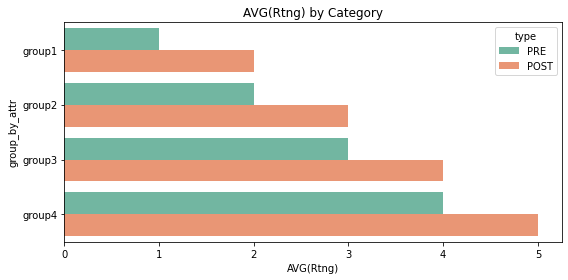

In [15]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x="value", y="group_by_attr", hue='type',
                 data=df_graph,
                 palette='Set2',
                 errwidth=0).set(title='AVG(Rtng) by Category')
plt.xlabel('AVG(Rtng)')
# plt.xlabel("Type")
#out_filename = 'bar_graph2.jpg'
plt.tight_layout()
#plt.savefig(out_filename, dpi=500)
plt.draw()

In [2]:
###TODO: extract from sql query
import re

In [24]:
import sqlparse
from sqlparse.sql import Identifier, IdentifierList, Function

def extract_aggregate_functions(query):
    parsed_query = sqlparse.parse(query)[0]
    results = []

    def process_token(token):
        if isinstance(token, Identifier):
            for child_token in token.tokens:
                if isinstance(child_token, Function):
                    function_name = child_token.get_name()
                    attribute_name = child_token.get_parameters()[0].value
                    attribute_name = attribute_name.split('.')[-1]

                    # Extract the alias after AS
                    #alias = token.value.split("AS")[-1].strip()

                    #results.append((function_name.upper(), attribute_name, alias))
                    results.append((function_name.upper(), attribute_name))
                    break

    for token in parsed_query.tokens:
        if isinstance(token, IdentifierList):
            for identifier in token.get_identifiers():
                process_token(identifier)
        else:
            process_token(token)

    return results

query = """
SELECT T1.category, AVG(T2.rating) AS rating
FROM amazon_product AS T1, amazon_review AS T2
WHERE T1.pid = T2.pid
GROUP BY T1.category
"""


aggregates = extract_aggregate_functions(query)

print(aggregates)


[('AVG', 'rating', 'rating')]


In [28]:
##### how-to query
###TODO: IP optimization, but results not right

In [38]:
import pulp

def optimize_top_5_bucketized(df, get_query_output, c_from, c_to, num_bins):
    # Create bins
    bins = np.linspace(c_from, c_to, num_bins + 1)
    

    # Define the problem
    prob = pulp.LpProblem("Top5_C_Optimization_Bucketized", pulp.LpMaximize)

    # Define variables
    c_vars = [pulp.LpVariable(f"c_{i}", lowBound=0, upBound=1, cat="Binary") for i in range(num_bins)]

    # Define the objective function
    AT_values = [get_query_output(df,'avg','rating',[],[],[],[],['price'],[bins[i]],['*'],'',{})for i in range(num_bins)]

    prob += pulp.lpSum([c_vars[i] * AT_values[i] for i in range(num_bins)])

    # Constraint: Only select 5 values of c
    prob += pulp.lpSum(c_vars) == 5

    # Solve the problem
    prob.solve()

    # Get the optimal solution
    optimal_bin_indices = [i for i in range(num_bins) if c_vars[i].varValue > 0.5]
    optimal_bin_ranges = [(bins[i], bins[i+1]) for i in optimal_bin_indices]

    return optimal_bin_ranges, pulp.value(prob.objective)


In [39]:
x,y = optimize_top_5_bucketized(df_new, get_query_output, 400, 1000, 10)

[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999,

In [40]:
x

[(400.0, 460.0),
 (460.0, 520.0),
 (520.0, 580.0),
 (580.0, 640.0),
 (640.0, 700.0)]

In [41]:
y

18.94405315528505

In [ ]:
#draw table
result_ls = [(400.0, 18.94405315528505),
 (460.0, 18.94405315528505),
 (520.0, 18.94405315528505),
 (580.0, 18.94405315528505),
 (640.0, 18.94405315528505)]

In [29]:
###code from 9.py


import time
import numpy as np
import pandas as pd
from collections import namedtuple, Counter
import copy

# import sys,json
# config_file=open('../../config.json','r')
# configs=json.load(config_file)
# print (configs)
# max_time=int(configs['max_runtime'])*60*60

FileNotFoundError: [Errno 2] No such file or directory: '../../config.json'

In [ ]:


#not use
def random_logit(x):
    z = 1./(1+np.exp(-x))
    #print(z) 
    s = np.random.binomial(n=1, p=z)

    return s
def roundlst(x):
    l=[]
    for v in x:
        if v>0.5:
            l.append(1)
        else:
            l.append(0)
    return l
def roundl(x,th):
    l=[]
    for v in x:
        if v>th:
            l.append(1)
        else:
            l.append(0)
    return l

def roundl4(x,th):
    l=[]
    for v in x:
        if v<=th:
            l.append(0)
        elif v<=2*th:
            l.append(1)
        elif v<=3*th:
            l.append(2)
        else:# v<=4*th:
            l.append(3)
    return l
from sklearn.preprocessing import KBinsDiscretizer

def bucketize(lst,num_buckets):
    maxval=max(lst)
    minval=min(lst)
    binlst=[minval-0.001]
    i=0
    labels=[]
    size=(maxval-minval)/num_buckets
    while i<num_buckets:
        binlst.append(binlst[-1]+size)#0.001)
        labels.append(i)
        i+=1
    binlst[-1]+=0.001
    return (pd.cut(x=lst, bins=binlst,labels=labels),binlst)




def get_data(N,seed,num_bins):
    #N=10000
    np.random.seed(seed)
    S=np.random.binomial(n=1, p=0.5,size=N)
    A=np.random.binomial(n=2, p=0.5,size=N)
    noise1=np.random.binomial(n=2, p=0.01,size=N)
    noise2=np.random.binomial(n=2, p=0.01,size=N)
    noise3=np.random.binomial(n=2, p=0.01,size=N)
    noise4=np.random.binomial(n=2, p=0.01,size=N)
    St=((2*S+A+ noise1 )/2)
    Cred=np.random.binomial(n=2, p=0.21,size=N)#np.array(((0.5*S+1.5*A+ noise1 )/2))
    
    sav=np.array(((S+A+noise2)/3))
            
    hous=np.array(((S+noise3)/2))
    bins={}
    #X1 = (2*S+A+np.random.normal(loc=0.0, scale=0.2, size=N))#(np.random.normal(loc=100.0, scale=1.16, size=N)) # N(0,1)
    #X2 =(3*A+2*S+np.random.normal(loc=0.0, scale=0.2, size=N))#random_logit(100*X1)#+np.random.normal(loc=0.0, scale=0.16, size=N)
    #Y = random_logit((A+3*St+2*sav+hous)/50)
    Y = ((A+St/3+sav/3+hous/3+noise4))#+Cred*0.01))
    df=pd.DataFrame(S,columns=['S'])
    df_U=pd.DataFrame(S,columns=['S'])
    df_U['noise1']=noise1
    df_U['noise2']=noise2
    df_U['noise3']=noise3
    df_U['noise4']=noise4
    df['A']=A
    df['S']=S
    df['St_orig']=St
    df['Cred_orig']=Cred
    df['sav_orig']=sav
    df['hous_orig']=hous
    (df['St'],bins['St']) = bucketize(St,num_bins)
    (df['Cred'],bins['Cred']) = bucketize(Cred,num_bins)
    (df['sav'],bins['sav']) = bucketize(sav,num_bins)
    (df['hous'],bins['hous']) = bucketize(hous,num_bins)
    df['Y']=Y
    
    
    return (df,df_U,bins)
def causal_effect(dolst,df,df_U):

    N=df.shape[0]
    if 'S' in dolst.keys():
        S=np.array([dolst['S']]*df.shape[0])#Construct a list of same size as df
    else:
        S=df['S']
        
        
    if 'A' in dolst.keys():
        A=np.array([dolst['A']]*df.shape[0])#Construct a list of same size as df
    else:
        A=df['A']


    noise1=df_U['noise1']
    noise2=df_U['noise2']
    noise3=df_U['noise3']
    noise4=df_U['noise4']
    if 'St' in dolst.keys():
        St= np.array([dolst['St']]*df.shape[0])
    elif 'A' in dolst.keys() or 'S' in dolst.keys():
        St= np.array(roundl((2*S+A+ noise1 )/2,1))
    else:
        St=df['St']
        
    if 'sav' in dolst.keys():
        sav=np.array([dolst['sav']]*df.shape[0])
    elif 'A' in dolst.keys() or 'S' in dolst.keys():
        sav=np.array(roundl((S+A+noise2)/3,0.5))
    else:
        sav=df['sav']
        
    if 'hous' in dolst.keys():
        hous=np.array([dolst['hous']]*df.shape[0])
    elif 'A' in dolst.keys() or 'S' in dolst.keys():
        hous=np.array(roundl((S+noise3)/2,0.5))
    else:
        hous=df['hous']
        
    if 'Cred' in dolst.keys():
        Cred=np.array([dolst['Cred']]*df.shape[0])
    elif 'A' in dolst.keys() or 'S' in dolst.keys():
        Cred=np.array(roundl((0.5*S+1.5*A+ noise1 )/2,1))
    else:
        Cred=df['Cred']  

    #print (St)
    #X1 = (2*S+A+np.random.normal(loc=0.0, scale=0.2, size=N))#(np.random.normal(loc=100.0, scale=1.16, size=N)) # N(0,1)
    #X2 =(3*A+2*S+np.random.normal(loc=0.0, scale=0.2, size=N))#random_logit(100*X1)#+np.random.normal(loc=0.0, scale=0.16, size=N)
    #Y = random_logit((A+3*St+2*sav+hous)/50)
    Y = roundlst((St/3+sav/3+hous/3+noise4))
    df=pd.DataFrame(np.array(list(S)),columns=['S'])
    

    df['A']=np.array(list(A))
    #print(df)
    df['S']=np.array(list(S))
    df['St']=np.array(list(St))
    df['sav']=np.array(list(sav))
    df['hous']=np.array(list(hous))
    df['Cred']=np.array(list(Cred))
    df['Y']=np.array(list(Y))
    
    return df
    #For each variable in dolst, change their descendants
        
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression


def get_val(row,target,target_val):
    i=0
    while i<len(target):
        #print (row[target[i]],target_val[i])
        if not int(row[target[i]])==int(target_val[i]):
            return 0
        i+=1
    return 1

def get_prob_o_regression(df,conditional,conditional_values,target,target_val):
    new_lst=[]
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
    
    X=df[conditional]
    regr = LogisticRegression(random_state=0)#RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X, new_lst)
    return (regr.predict_proba([conditional_values])[0][1])
    #return(regr.predict([conditional_values])[0])
    

def get_logistic_param(df,conditional,target,target_val):
    new_lst=[]
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
    X=df[conditional]
    regr = LinearRegression()
    regr.fit(X, df[target])
    print (regr.coef_)
    print (regr.intercept_)
    return (regr.coef_.tolist()[0],[regr.intercept_])
    #print(regr.get_params())
    

import math
from mip import Model, xsum, maximize, minimize, BINARY
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression

debug=False
def get_combination(lst,tuplelst):
    i=0
    new_tuplelst=[]
    if len(tuplelst)==0:
        l=lst[0]
        for v in l:
            new_tuplelst.append([v])
        if len(lst)>1:
            return get_combination(lst[1:],new_tuplelst)
        else:
            return new_tuplelst
    

    currlst=lst[0]
    for l in tuplelst:
        
        for v in currlst:
            newl=copy.deepcopy(l)
            newl.append(v)
            new_tuplelst.append(newl)
        
    if len(lst)>1:
        return get_combination(lst[1:],new_tuplelst)
    else:
        return new_tuplelst
      
def get_C_set(df,C):
    lst=[]
    for Cvar in C:
        lst.append(list(set(list(df[Cvar]))))
        
    combination_lst= (get_combination(lst,[]))
    
    return combination_lst

import copy

def optimization(df,A,aval,Adomain,klst,kval,alpha,betalst,beta0):
    
    backdoorvals=get_C_set(df,klst)
    print (backdoorvals,len(A),len(betalst))
    
    betalst_backdoor=betalst[len(A):]
    sum_backdoor=0
    for lst in backdoorvals:
        iter=0
        sampled_df=copy.deepcopy(df)
        tmpsum=0
        while iter<len(lst):
            sampled_df=sampled_df[sampled_df[klst[iter]]==lst[iter]]
            tmpsum+=betalst_backdoor[iter]*lst[iter]
            iter+=1
        sum_backdoor+= tmpsum*(sampled_df.shape[0]*1.0/df.shape[0])
        print("shapes",sampled_df.shape[0],df.shape[0],tmpsum)
    print (sum_backdoor)
     
    
    
    m = Model("Test")
    i=0
    var_lst=[]
    var_map={}
    while i<len(A):
        j=0
        while j<len(Adomain[i]):

            var_lst.append(m.add_var(var_type=BINARY))
            var_map[len(var_lst)-1]=(i,j)
            j+=1
        i+=1
    print ("beta list is ",betalst,beta0)
    cost_lst=[]
    constr_lst=[]
    constr_lst.append(beta0)
    iter=0
    i=0
    while i<len(A):
        j=0
        del_cons=[]
        while j<len(Adomain[i]):
            '''
            if Adomain[i][j]==aval[i]:
                constr_lst.append(betalst[i]*Adomain[i][j])
                j+=1
                continue
            '''
            constr_lst.append(betalst[i]*var_lst[iter]*(Adomain[i][j]))
            del_cons.append(var_lst[iter])
            iter+=1
            j+=1
        m += xsum(del_cons) <= 1
        i+=1
    constr_lst.append(sum_backdoor)
    '''i=len(A)
    while i<len(betalst):
        constr_lst.append(betalst[i]*kval[i-len(A)])
        i+=1
    '''

    print (constr_lst)
    #m+=xsum(constr_lst)>=math.log(alphak*1.0/(1-alphak))
    m.objective = maximize(xsum(constr_lst))
    m.optimize()
    if m.num_solutions:
        print('Objective value %g found:'
                  % (m.objective_value))
        i=0
        score=0
        gt_score=0
        while i<len(var_lst):
            print (i,var_lst[i].x,var_map[i], Adomain[var_map[i][0]][var_map[i][1]])
            if var_lst[i].x==1:
                vallst=[]
                if var_map[i][0]==0:
                    vallst=bins['St']
                elif var_map[i][0]==1:
                    vallst=bins['sav']
                elif var_map[i][0]==2:
                    vallst=bins['hous']
                else:
                    vallst=bins['Cred']
                print (vallst,(vallst[var_map[i][1]],vallst[var_map[i][1]+1]))
                print ("sc",betalst[var_map[i][0]]*((vallst[var_map[i][1]]+vallst[var_map[i][1]+1])/2))
                score+= betalst[var_map[i][0]]*((vallst[var_map[i][1]]+vallst[var_map[i][1]+1])/2)
                gt_score+=betalst[var_map[i][0]]*((vallst[-1]))
            i+=1
        print ("sum backdoor",sum_backdoor,score) 
        print ("score is ",score+sum_backdoor+beta0,gt_score+sum_backdoor+beta0)
        print ("score is ",score,sum_backdoor,beta0)#,gt_score+sum_backdoor+beta0)
        return (score+sum_backdoor+beta0)*1.0/(gt_score+sum_backdoor+beta0),(gt_score+sum_backdoor+beta0)
    


# In[ ]:





# In[199]:
scores={}
times={}
total_time=0
opt_times={}
opt_scores={}
for num_bins in [1,2,4,6,8,10]:
    print (num_bins)
    i=0
    lst=[]
    while i<num_bins:
        lst.append(i+1)
        i+=1
    
    (df,df_U,bins)=get_data(20000,0,num_bins)

    print (df)
    A=['St_orig','sav_orig','hous_orig','Cred_orig']#,'housing','employment']
    aval=[1,0,0]

    klst=['A','S']
    kval=[]

    target='Y'
    start=time.time()
    conditionals=copy.deepcopy(A)
    conditionals.extend(klst)
    #print (conditionals)
    (beta_lst,[[beta0]])=get_logistic_param(df,conditionals,[target],[1])
    print(beta_lst,beta0)


    Adomain=[lst,lst,lst,lst]#,[0,1],[0,1,2,3,4]]#List of list where each list is domain of each variable in A

    scores[num_bins],gt_score=optimization(df,A,aval,Adomain,klst,kval,0.8,beta_lst,beta0)
    end=time.time()
    times[num_bins]=end-start
    if total_time >= max_time:
        opt_times[num_bins]=opt_times[num_bins-2]*opt_times[2]
        opt_scores[num_bins]=opt_scores[num_bins-2]
        continue
    start=time.time()
    domain_lst=get_combination(Adomain,[])
    maxval=0
    for lst in domain_lst:
        print(lst)
        St_bins=bins['St']
        sav_bins=bins['sav']
        hous_bins=bins['hous']
        cred_bins=bins['Cred']
        (beta_lst,[[beta0]])=get_logistic_param(df,conditionals,[target],[1])
        print (conditionals,beta_lst)
        stval=beta_lst[0]*((St_bins[lst[0]-1]+St_bins[lst[0]])/2)
        savval=beta_lst[1]*((sav_bins[lst[0]-1]+sav_bins[lst[0]])/2)
        housval=beta_lst[2]*((hous_bins[lst[0]-1]+hous_bins[lst[0]])/2)
        credval=beta_lst[3]*((cred_bins[lst[0]-1]+cred_bins[lst[0]])/2)
    
        backdoorvals=get_C_set(df,klst)
    
        betalst_backdoor=beta_lst[len(A):]
        sum_backdoor=0
        for lst in backdoorvals:
            iter=0
            sampled_df=copy.deepcopy(df)
            tmpsum=0
            while iter<len(lst):
                sampled_df=sampled_df[sampled_df[klst[iter]]==lst[iter]]
                tmpsum+=betalst_backdoor[iter]*lst[iter]
                iter+=1
            sum_backdoor+= tmpsum*(sampled_df.shape[0]*1.0/df.shape[0])

            print(sampled_df.shape[0])
        if sum_backdoor+stval+savval+housval+credval> maxval:
            maxval=sum_backdoor+stval+savval+housval+credval
        print (sum_backdoor+stval+savval+housval)
    print ("sum backdoor",sum_backdoor,stval,savval,housval) 
    end=time.time()
    opt_times[num_bins]=end-start
    opt_scores[num_bins]=(maxval+beta0)*1.0/gt_score
    print (end-start)
    total_time+=opt_times[num_bins]
#(A,aval,Adomain,klst,kval,alpha,betalst,beta0):

print (scores)
print (opt_scores)
print(times)
print(opt_times)